# Assignment group 2: Network and exploratory data analysis

## Module A _(65 pts)_ Exploring averages, sentiment, and time series
In this section we're going to experiment with the word-based text sentiment data generated by a research project documented in the following publication:

- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752#pone.0026752.s001

These data are packaged with the assignment in the following directory:

- `./data/Data_Set_S1.txt`

Here's the caption describing the data, from their paper:

> Data from Mechanical Turk study. labMT 1.0 = language assessment by Mechanical Turk 1.0. In the supplementary tab-delimited file named Data Set S1, we provide our set of 10,222 words, their average happiness evaluations according to users on Mechanical Turk, and other information as described below. Please cite the present paper when using this word set. Within papers, we suggest using the abbreviation labMT 1.0 when referencing this data set. The words are ordered according to average happiness (descending), and the file contains eight columns: (1) word, (2) rank, (3) average happiness (50 user evalutions), (4) standard deviation of happiness, (5) Twitter rank, (6) Google Books rank, (7) New York Times rank, (8) Music Lyrics rank. The last four columns correspond to the ranking of a word by frequency of occurrence in the top 5000 words for the specified corpus. A double dash ‘–’ indicates a word was not found in the most frequent 5000 words for a corpus. Please see the main paper for more information regarding this data set.

Note, the paper refers to the scorings as 'happiness' values, but these are also referred to as 'valence', which is a measure of poistive/negative 'affect', or 'sentiment'.

In [1]:
#Libraries in use:
from pprint import pprint
from collections import defaultdict
import re
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from dateutil.parser import parse
from datetime import datetime

In [2]:
%matplotlib inline 

__A1.__ _(2 pts)_ To start, load the dataset with `pandas` into a dataframe and print its `.head()` and `tail()`. Do the lines output make sense in the context of the description?

\[Hint. Since the folks who put these data together put a few lines (3) of descriptive text&mdash;not data&mdash;use the `skiprows` argument in `pd.read_csv()` to start parsing/loading into the dataframe at the appropriate line. Just be sure to keep the header!!

In [3]:
df_sentiment = pd.read_table("./data/Data_Set_S1.txt", skiprows=[0], header=1)

In [4]:
df_sentiment.columns

Index(['word', 'happiness_rank', 'happiness_average',
       'happiness_standard_deviation', 'twitter_rank', 'google_rank',
       'nyt_rank', 'lyrics_rank'],
      dtype='object')

In [5]:
df_sentiment.shape

(10222, 8)

In [6]:
df_sentiment.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [7]:
df_sentiment.tail()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107
10221,terrorist,10222,1.30,0.9091,3576,--,3026,--


__A2.__ _(3 pts)_ Review the data with descriptive statistics. In particular, create a histogram of the `'happiness_average'` column, labeling axes clearly, and plot/print out the locations of the mean and median in this same picture as `'red'` and `'blue'` vertical lines respectively. In the response box below indicate if you believe these data are skewed (the center should be `5`, i.e., neutral), and if so indicate the direction of skew (high or low) and how these information justify that view.

<font color=blue> The data regarding the average happiness level is skewed left or negatively skewed since the median is higher than the mean(low skewness). This means that the left tail is longer; the mass of the distribution is concentrated on the right of the figure.</font>

Text(5.97752,857.115,'Median: 5.44')

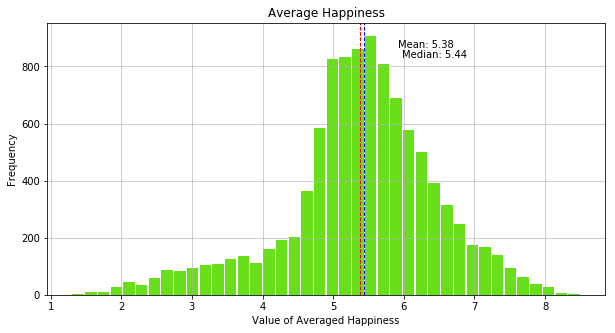

In [8]:
# An "interface" to matplotlib.axes.Axes.hist() method
firsthist = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=df_sentiment['happiness_average'], bins=40, color='#69DF1C', 
                            alpha=1, rwidth=0.9)
plt.grid(alpha=0.75)
plt.xlabel('Value of Averaged Happiness')
plt.ylabel('Frequency')
plt.title('Average Happiness')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.axvline(df_sentiment['happiness_average'].mean(), color='red', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(df_sentiment['happiness_average'].mean() + df_sentiment['happiness_average'].mean()/10, 
         max_ - max_/10,
         'Mean: {:.2f}'.format(df_sentiment['happiness_average'].mean()), verticalalignment='bottom',
        horizontalalignment='left')
plt.axvline(df_sentiment['happiness_average'].median(), color='blue', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(df_sentiment['happiness_average'].median() + df_sentiment['happiness_average'].mean()/10, 
         max_ - max_/10, 'Median: {:.2f}'.format(df_sentiment['happiness_average'].median()), verticalalignment='top',
        horizontalalignment='left')

__A3.__ _(3 pts)_ The `'happiness_average'` column was created as an average of 50 survey responses and is supplementally associated to the standard deviations from these 50-respondant cohorts. Make a scatter plot of the `'happiness_standard_deviation'` (vertical) against the `'happiness_average'` (horizontal) column. Again, be sure to clearly label axes and adjust any arguments to make this picture as clear and interpretable as possible.

Discuss any relationship you visually observe between these columns in the response box below. Since the `y` variable is a standard deviation, do you think there's a particular range (of the `x`/horizontal variable, `'happiness_average'`) over which the data are specifically less reliable, according to this picture? If so, include some discussion over why you think this may the case, considering the neutral criterion for 'stop word removal' that we follow in part __A10__.

\[Hint. Be sure to utilize the `color` and `alpha` arguments to highlight variations in point density.\]

<font color=blue>According to the plot, if standard deviation is smaller, it indicates that the data points tend to be close to the mean or the expected value. A high standard deviation shows that the data is widely spread (less reliable) and a low standard deviation shows that the data are clustered closely around the mean (more reliable). Therefore, we can see that for average happiness levels around 5 or 6 the data is more reliable. On the other hand, with happiness levels around 3-4 the standard deviation is high and data is far from the mean.</font>

<font color=blue>Overall, data points that are in the dense regions of the plot are more reliable than the onese in the sparse areas.</font>

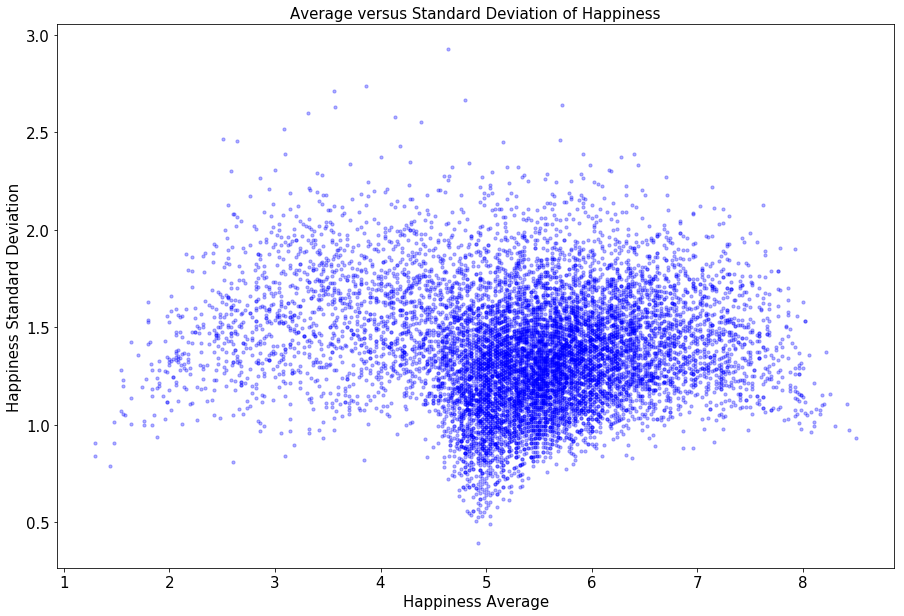

In [9]:
## set the figure dimensions
scat_fig = plt.figure(figsize = (15, 10))
    
## make a scatter plot
_  = plt.scatter(
    df_sentiment['happiness_average'],df_sentiment['happiness_standard_deviation'], 
    color = "blue", s = 10, alpha = 0.3)

## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Average versus Standard Deviation of Happiness", fontsize = 15)

## Set the y-label
_ = plt.ylabel("Happiness Standard Deviation", fontsize = 15)

## Set the y-label
_ = plt.xlabel("Happiness Average", fontsize = 15)

__A4.__ _(2 pts)_ One of the columns is labeled `'nyt_rank'`, which indicates the rank (by frequency) of each given word in a corpus of all New York Times (NYT) articles from the 20-year period, 1987&ndash;2007. This is provided because the ~10k words that constitute the data were, in part, drawn from this 20-year corpus of articles. Thus, the words in `./data/Data_Set_S1.txt` data are specially tuned for application to a corpus text drawn from the NYT.

So to match, frequencies are provided for the same ~10k words for each daily issue of the NYT in the 20-year corpus. These are contained in the file:

- `"./data/nyt.csv"`

which will available in the data directory after the compressed file is inflated, i.e., after unzipping from the command line in the data directory:

```
>>> unzip nyt.csv.zip
```

Load these data using `pandas`, store the `.transpose()`'d dataframe as `nyt`, and then set the dataframe's `.columns` attribute to the `'word'` column of the valence dataframe. Then, print the `.shape`, `'.head()`, and `'.tail()'` to confirm they are compatible with the valence data, e.g., for inner products. In the response box below, record the dimensions $m$ and $n$ as the number of times and words in the dataset (the matrix dimensions). 

Note: with these data, we're thinking about _time_ as the independent, '`x`' variable, so it's convenient to have the times along the rows, and words along the columns&mdash;this is the 'why' for the application of `.transpose()` from the shape of the `nyt` data on file.

<font color=blue>The dimensions of nyt matrix are $7475 \times 10222$ and can be multiplied by the sentiment matrix which was a $10222 \times 8$ matrix. The product would be a $7475 \times 8$ matrix</font>

In [10]:
nyt_load_init = pd.read_csv("./data/nyt.csv")

In [11]:
nyt_load_init.shape

(10222, 7475)

In [12]:
nyt = nyt_load_init.transpose()

In [13]:
nyt.columns = df_sentiment['word']

In [14]:
nyt.shape

(7475, 10222)

In [15]:
nyt.head()

word,laughter,happiness,love,happy,laughed,laugh,laughing,excellent,laughs,joy,...,died,kill,killed,cancer,death,murder,terrorism,rape,suicide,terrorist
1987-01-01,0,0,6,9,0,3,1,2,0,9,...,14,2,18,38,26,18,1,1,0,2
1987-01-02,0,2,20,12,0,0,2,5,1,0,...,19,7,27,1,24,16,1,0,1,0
1987-01-03,0,0,5,3,0,0,0,2,0,2,...,14,4,16,2,21,11,2,0,0,1
1987-01-04,7,1,44,19,1,9,3,14,4,7,...,30,14,38,33,60,20,18,27,15,32
1987-01-05,0,0,11,1,1,1,1,4,2,1,...,14,1,47,15,22,2,0,0,2,1


In [16]:
nyt.tail()

word,laughter,happiness,love,happy,laughed,laugh,laughing,excellent,laughs,joy,...,died,kill,killed,cancer,death,murder,terrorism,rape,suicide,terrorist
2007-06-15,0,2,37,20,3,7,2,8,1,6,...,29,7,27,5,29,13,6,1,6,8
2007-06-16,0,2,10,3,0,2,1,3,1,1,...,22,6,10,7,22,12,4,0,7,7
2007-06-17,1,8,115,33,7,7,7,10,8,11,...,70,20,25,32,75,20,4,0,17,6
2007-06-18,1,1,29,1,4,0,1,7,1,2,...,26,3,16,28,19,2,5,2,7,10
2007-06-19,2,1,21,6,1,3,2,5,0,1,...,38,6,24,28,28,6,4,0,6,6


__A5.__ _(5 pts, total)_ While the valence values were detemined by survey and may be skewed, the histogram from __A2__ doesn't reflect the frequency with which the words were actually used. For this part, your job is to repeate the histogram picture, but with weighted values, including the computation of mean and median lines.

So, write a function that computes the mean and median as weighted quantities, according to the occurrence of words in the articles. So intuitively, if the most positive word (`'laughter'`, `happiness_average = 8.5`) appeared 100 times across the NYT, there would be 100 instances of the value 8.5 to incorporate into each of the mean and median calculations.

When this is complete, discuss any changing/stationary features of the centrality statistics and histogram that you observe as compared to the output in __A2__, using the response box below.

In [17]:
df_sentiment = pd.read_table("./data/Data_Set_S1.txt", skiprows=[0], header=1) 
#loading it again to be sure that it is the original df

<font color=blue>Previously the data was skewed to the left and the mean and median was further apart. Now the data is more balanced, the mean and median are closer and the skewness of the data is not very obvious(now it is slightly skewed to the right.)</font>

- [x] __Weights.__ _(1/5 pts)_
To start, total the frequencies in the NYT data across time (collapsing rows) into a single vector: $\vec{F} = [F_1, \cdots, F_n]$ (use the `axis` argument in the `.sum()` method and name the resulting object `F`). Using this, record the total number of words in the entire dataset: `N = F.sum()`. Print `N` once calculated, below.

In [18]:
F = np.array(nyt.sum(axis=0))
N = F.sum()
print(F[:10])
print("")
print(N)
print(type(F))
print(F.shape)

[ 10618   8977 210747  82857  12254  20241  12698  40176   6661  24249]

868729965
<class 'numpy.ndarray'>
(10222,)


- [x] __Mean.__ _(1/5 pts)_
For the mean you'll have to use $\vec{F}$ in a sum formula that groups the contributions of words according to their $F_i$ weights:
$$
\overline{h} = \frac{\sum_{i=1}^nh_i\cdot F_i}{\sum_{i=1}^nF_i} = \frac{1}{N}\sum_{i=1}^nh_i\cdot F_i,
$$
Here, the $h_i$ indicate the valence values for the words, and the denominator $N = \sum_{i=1}^nF_i$ is equal to the total number of words that appeared in the dataset (as above). Print the mean once calculated, below.

In [19]:
h  = np.array(df_sentiment['happiness_average'])
print(h[:10])

[8.5  8.44 8.42 8.3  8.26 8.22 8.2  8.18 8.18 8.16]


In [20]:
def weighted_mean(N, h, F):
    hbar = (1/N)*(h.dot(F))
    return hbar

In [21]:
hbar = weighted_mean(N, h, F)
print(hbar)

5.368698927128638


- [x] __Median.__ _(1/5 pts)_
While the above mean can be easily computed  via sums and dot products the 'weighted' median is more challenging. In particular, the median considers the middle-most word according to a sort from low to high by valence. 

Since we now have frequencies of occurrence for each word, we have to _cumulatively_ count up the frequencies in order of increasing (or decreasing) valence. The median will be the word/valence over which half&mdash;$N/2$&mdash;of the frequency in $\vec{F}$ accumulates.

The valence data are already sorted from high to low. But this is a special case&mdash;we're looking for the 50th percentile. So, we can take cumulative sums of `F` to identify the word for which $N/2$ accumulates. In particular, use the `.cumsum()` method on `F` to identify the median word/valence appearing at $N/2$. Print the median once calculated, below.

In [22]:
def weighted_median(df, F):
    cumsum = F.cumsum()
    cutoff = F.sum() / 2.0
    median = df[cumsum >= cutoff].iloc[0]
    return median

In [23]:
median = weighted_median(df_sentiment, F)
print(median)

word                                 a
happiness_rank                    6029
happiness_average                 5.24
happiness_standard_deviation    0.9161
twitter_rank                         4
google_rank                          6
nyt_rank                             4
lyrics_rank                          6
Name: 6028, dtype: object


In [24]:
print(median[2]) #actual median value

5.24


- [x] __Histogram.__ _(1/5 pts)_
For the histogram, $\vec{F}$ can now be used as the value for the `weights` argument. Otherwise, you may reuse your histogram code from __A2__, including vertical lines at the centrality measures.

Text(5.77687,1.86922e+08,'Median: 5.24')

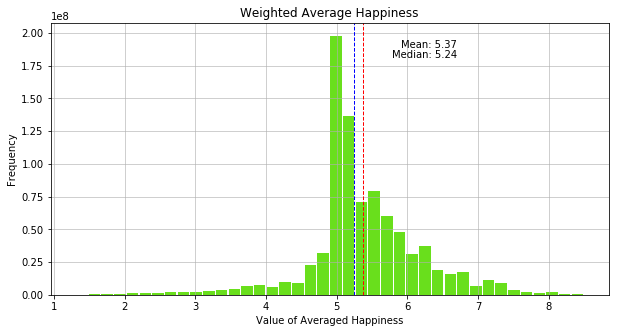

In [25]:
secondhist = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(x=df_sentiment['happiness_average'], bins=40, color='#69DF1C', 
                            alpha=1, rwidth=0.9, weights=F)
plt.grid(alpha=0.75)
plt.xlabel('Value of Averaged Happiness')
plt.ylabel('Frequency')
plt.title('Weighted Average Happiness')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.axvline(hbar, color='red', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(hbar + hbar/10, 
         max_ - max_/10,
         'Mean: {:.2f}'.format(hbar), verticalalignment='bottom',
        horizontalalignment='left')
plt.axvline(median[2], color='blue', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(median[2] + hbar/10, 
         max_ - max_/10, 'Median: {:.2f}'.format(median[2]), verticalalignment='top',
        horizontalalignment='left')

__A6.__ _(2 pts)_ The NYT data are timeseries data, but how can we utilize the temporal information? To get started, modify `nyt`'s to contain parsed `datetime` objects, utilizing the `dateutil.parser.parse()` function. When this is done, print the first 10 elements of the index.

\[Hint: to get/modify the index in a dataframe utilize the `.index` attribute.\]

In [26]:
nyt = nyt_load_init.transpose() # I am loading the data again to track what happens to the original data as I progress!
nyt.columns = df_sentiment['word']

In [27]:
nyt.index = [parse(x) for x in nyt.index]

In [28]:
nyt.index[:10]

DatetimeIndex(['1987-01-01', '1987-01-02', '1987-01-03', '1987-01-04',
               '1987-01-05', '1987-01-06', '1987-01-07', '1987-01-08',
               '1987-01-09', '1987-01-10'],
              dtype='datetime64[ns]', freq=None)

__A7.__ _(3 pts)_ Throughout this assignment we're going to want to be able to standardize the columns of our time series. So, your job here is to write a function called `standardize(ts)` that accepts a time series dataframe `ts` (like `nyt`) as input, and outputs a timeseries of same shape, containing the standardized columns of `ts`.

For `nyt`, standardizing the columns will allow comparability words, since they occur at very different frequencies. So when `standardize()` processes `nyt`, the $i^\text{th}$ word at time $t$ should be transformed to: 
$$
\frac{f_{t,i} - \mu_T(f_i)}{\sigma_T(f_i)}
$$

When this is complete, store the application of `standarize()` to `nyt` as `word_series` and exhibit its `.head()`.

**Just an observation:**

In [29]:
#here I checked to see whether we will get a zero division error or not 
#and it seems like we have 228 words with zero standard deviation. :(
zerostdwordlist = []
for eachcol in nyt.columns:
    if nyt[eachcol].std()==0:
        zerostdwordlist.append(eachcol)
print(zerostdwordlist[:10])
print(len(zerostdwordlist))

['bday', 'hahah', 'hahahah', '1st', 'hehehe', '#music', '4-bedroom', 'ahaha', '1980s', "80's"]
228


In [30]:
valuesofzerostdword = []
for eachzerostdword in zerostdwordlist:
    valuesofzerostdword.append(nyt[eachzerostdword][0])
print(valuesofzerostdword)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<font color=blue>Since the standard deviation is calculated by taking the sum of the squared deviations from the mean, a zero standard deviation can only be possible when all the values of a variable are the same (all equal to the mean). In this case, those variables have no discriminative power so they can be removed from the analysis. And in this case this value is zero! But by using pandas we can avoid this problem apparently! :D</font>

In [31]:
#cleaned_nyt = nyt.drop(nyt[zerostdwordlist], axis=1) 
#cleaned_nyt.head(2)

In [32]:
#cleaned_sentiment = df_sentiment[~df_sentiment['word'].isin(zerostdwordlist)] 
#cleaned_sentiment.head(2)

**Standardize function:**

In [33]:
def standardize(ts):
    stand_ts = (ts-ts.mean())/ts.std()
    return stand_ts

In [34]:
std_nyt = standardize(nyt) 

In [35]:
std_nyt.head()

word,laughter,happiness,love,happy,laughed,laugh,laughing,excellent,laughs,joy,...,died,kill,killed,cancer,death,murder,terrorism,rape,suicide,terrorist
1987-01-01,-0.683256,-0.538531,-0.765010,-0.220531,-0.84119,0.089344,-0.336031,-0.569551,-0.597978,1.528747,...,-1.016859,-0.891894,-0.073634,1.822090,-0.272173,1.127471,-0.505330,-0.438319,-0.828186,-0.365434
1987-01-02,-0.683256,0.358321,-0.282432,0.096849,-0.84119,-0.828024,0.144887,-0.063241,0.073075,-0.861586,...,-0.684841,0.097467,0.843213,-0.875830,-0.373859,0.857534,-0.505330,-0.645504,-0.664068,-0.543895
1987-01-03,-0.683256,-0.538531,-0.799480,-0.855291,-0.84119,-0.828024,-0.816949,-0.569551,-0.597978,-0.330401,...,-1.016859,-0.496149,-0.277378,-0.802914,-0.526388,0.182691,-0.397264,-0.645504,-0.828186,-0.454665
1987-01-04,2.683797,-0.090105,0.544845,0.837402,-0.32806,1.924078,0.625804,1.455689,2.086235,0.997562,...,0.045599,1.482572,1.963804,1.457506,1.456496,1.397409,1.331794,4.948506,1.633583,2.311487
1987-01-05,-0.683256,-0.538531,-0.592660,-1.066878,-0.32806,-0.522235,-0.336031,-0.232011,0.744129,-0.595993,...,-1.016859,-1.089766,2.880651,0.145004,-0.475545,-1.032027,-0.613396,-0.645504,-0.499950,-0.454665


__A8.__ _(10 pts)_ Now write a function called `plot_series(ts, start, stop)` that plots the columns of a time series `ts`, like `word_series` (or `nyt`), as line plots of a range in time specified by strings `start` and `stop` in the format `yyyy-mm-dd`. Be sure to make your visualization as interpretable as possible, specifically utilizing both `label`s for columns and transparency of line color (`alpha`).

For development and testing, select just a few word-columns: `word_series[words]` (slicing out columns results in a smaller set of valid series) and a well-understood range of time (`start`/`stop`). In particular, use:

- `words = ['new'`, `'year'`, `"year's"`, `'two'`, `'eve'`, `'thousand']`
- `start = '1999-12-15'`
- `stop = '2000-01-15'` 

for development, and exhibit your code's output using these parameters.

When complete, comment in the response box below on the location of peaks, and be sure to discuss why you think the observed spike(s) exist.

\[Hint. to retrieve values in the temporal plotting range defined by `start` and `stop`, use boolean masks.\]

<font color=blue>The dataset starts on a Thursday, I believe the peakes are on a certain day for example Sunday where it is more probable to have the word "new". Also, we generally have more words on Sundays. Also, the word "year" happens more around the new year. Overall, we can see a weekly trend in most of the words and generally more words are used in certain days.</font>

In [36]:
def plot_series(ts, start, stop):
    datestart = datetime.strptime(start, '%Y-%m-%d')
    datestop = datetime.strptime(stop, '%Y-%m-%d')
    sub_ts = ts.loc[(ts.index >= datestart) & (ts.index <= datestop)]
    Date = sub_ts.index
    Word = sub_ts.loc[:, :]
    plt.figure(figsize = (20, 7))
    plt.plot(Date, Word, alpha=0.7)
    plt.grid(alpha=0.5)
    plt.xlabel('Date/Time')
    plt.ylabel('Value')
    plt.title('Time Series')
    plt.gca().legend([x for x in Word.columns])
    plt.xticks(rotation=60)
    plt.show()

In [37]:
testing_nyt = std_nyt[['new', 'year', "year's", 'two', 'eve', 'thousand']]

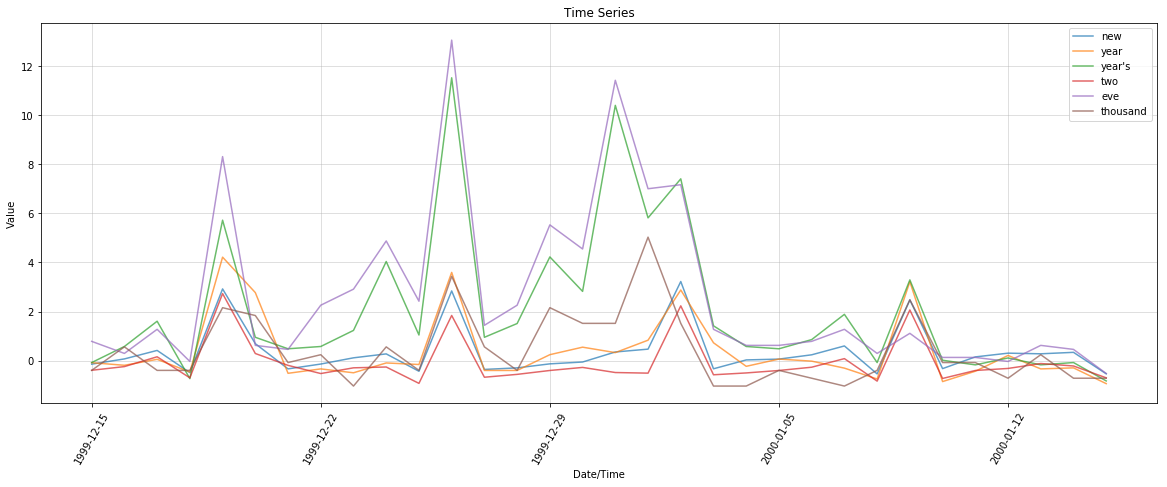

In [38]:
plot_series(testing_nyt, start = '1999-12-15', stop = '2000-01-15')

__A9.__ _(7 pts)_ One common aspect of time series' is the presence of 'uninteresting' trends (at least from the point of view of the desired analysis). Generally, de-trending can be done by characterizing a trend&mdash;a regularity desired for removal&mdash;and  removing it, either by subtraction or division. Right now, our interest will be focused on spikes that may represent events outside of an 'everyday routine', so we will be _de-trending weekly signatures_. 

So, create a function called `remove_weekly(ts)` that takes a time series `ts`, computes the average day-of-week values for each column, and then divides column values by their respective averages from the corresponding days of week. The function should `return` a dataframe the same shape as `ts`.

When this is complete, again, apply your code to just a few word-columns: `word_series[words]`. In partcular, use:

- `words = ['new'`, `'year'`, `"year's"`, `'two'`, `'eve'`, `'thousand']`

and pass the result, `detrend_weekly(word_series[words])` through `plot_series()` over the range of time defined by:

- `start = '1999-12-15'`
- `stop = '2000-01-15'`

Finally, comment in the markdown cell below as to any changes that occur when the weekly trend is removed. What do you think these changes tell you about the data, i.e., word frequencies in NYT articles? Do you think the issues for the different days of the week were generally of the same size?

\[Hint: Python support 'triple-index' slicing, for which the third index indicates a step-size for the slice, i.e, for a list `lst`, `lst[0:401:10]` will result in every `10`th value from index `0` to `400`, i.e., `[0, 10, 20, ..., 400]`.\]

<font color=blue>The frequency of the words droped because we removed the trend. Some of the peaks flattened a bit and we can see a clear distinction between the weekly peaks which can be analyzed for a pattern and not due to the trend or a foreseeable reason.</font>

In [39]:
def detrend_weekly(ts):
    #find the weekly average matrix:
    weekly_avg = [np.mean(ts[j:ts.shape[0]+1:7]) for j in range(7)] #averages of each weekday for all the words
    avg = np.zeros(shape = ts.shape)
    for i in range(7):
        avg[i:avg.shape[0]+1:7] = weekly_avg[i]
    #find the division:
    out_ts = ts/avg
    #add the Dates to the values  
    return out_ts

In [40]:
detrended_nyt_std = detrend_weekly(std_nyt)

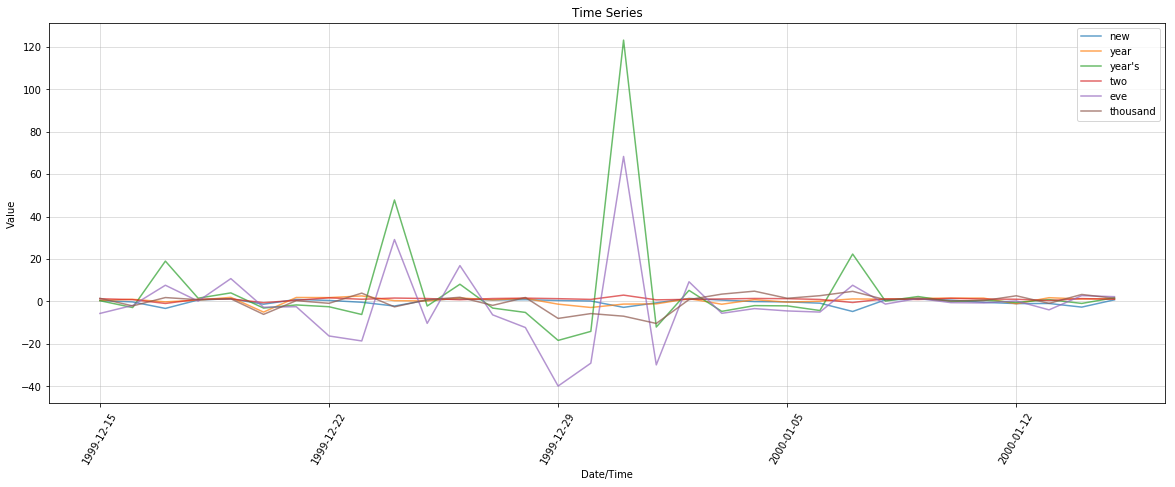

In [41]:
words = ['new', 'year', "year's", 'two', 'eve', 'thousand']
start = '1999-12-15'
stop = '2000-01-15'
plot_series(detrended_nyt_std[words], start, stop)

__A10.__ _(8 pts)_ Next up, your job is to produce a function called `avgs(ts, stop = 0)`, which produces a timeseries of average valence values for a times series, `ts`, e.g., the entire 20-year range of `nyt`. 

In particular, for a given day, $t$, the average daily value should be

$$
\overline{h}_t = \frac{ \sum_{i=1}^nh_i\cdot f_{t, i}}{\sum_{i=1}^nf_{t,i}},
$$

The argument `stop` indicates the size of a 'stop word window' (see the valence-data authors' paper to supplement details) of valence values for words to be omitted from the calculation. So, if `stop = 1` and the $i^\text{th}$ word has valence $h_i$ inside the window (i.e., $h_i\in [4,6]$), then $h_i\cdot f_{t, i}$ and $f_{t, i}$ should be excluded from the above sum's numerator and denominator, respectively.

When this is complete, store the output of this function applied to `nyt` `for` each value of `stop` in `range(4)` as a column in a new time series dataframe called `avgs_series` under the column names `'avg-'+str(stop)`. Then, display these new columns using your `plot_series()` function over a new range, defined by: 

- `start = "2000-01-01"`
- `stop = "2003-12-31"` 

and discuss any differences you observe between the four different series defined by the stop word windows in the response box below.

\[Hint: use `.dot()` products and `.sum()` methods on boolean masks of `ts`, slicing the non-stop words for fast calculation.] 

<font color=blue>Since the stop words are the ones around the middle point, if the stop argument is larger, the data would be more conclusive and with lower noise because the words close to neutral was removed from results.</font>

In [42]:
def avgs(ts, stop):
    #one for each word, get the sentiment:
    h = np.array([x if np.abs(x-5) >= stop else 0 for x in df_sentiment['happiness_average']])
    otherh = np.array([1 if np.abs(x-5) >= stop else 0 for x in df_sentiment['happiness_average']])
    hbar = ts.dot(h)/ts.dot(otherh)
    return hbar

In [43]:
def make_avg_ts(ts):
    column_names = []
    for i in range(4):
        column_names.append(('avg-'+str(i), i))
    df = pd.DataFrame(index = ts.index)
    for eachcolumn in column_names:
        df[eachcolumn[0]]  = avgs(ts, eachcolumn[1])
    return df

In [44]:
avg_nyt = make_avg_ts(nyt)

In [45]:
avg_nyt.head()

,avg-0,avg-1,avg-2,avg-3
1987-01-01,5.339310,5.842626,5.801057,3.888601
1987-01-02,5.353210,5.884414,5.977164,4.244646
1987-01-03,5.328557,5.788138,5.644185,3.575101
1987-01-04,5.383349,5.960673,6.087651,4.229306
1987-01-05,5.343373,5.859886,5.900047,4.327791


In [78]:
start = "2000-01-01"
stop = "2003-12-31"

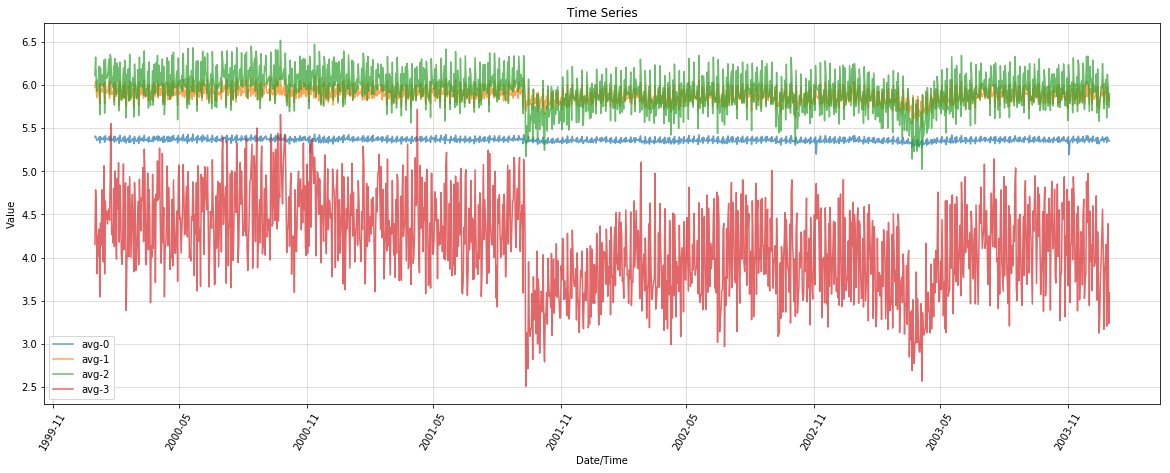

In [79]:
plot_series(avg_nyt, start, stop)

__A11.__ _(8 pts)_ One thing you might've noticed from the previous part was that the calculated averages were rather noisy, preventing us from observing long-term trends and big events. So, let's build a function called `smooth(ts, r = 1)` that takes a time series `ts` (e.g., `avgs_series`) and returns a same-shaped time series dataframe of _moving averages_ of the columns of your `series`.  

Averages are to be taken over the values in a 'window' of radius $r$ about a point in time $t$. In particular, the smoothed value at $t_\text{smooth}$ should be taken over all times $t$ for which 

$$t_\text{smooth} - r < t < t_\text{smooth} + r$$ 

For example, if we call the result `smooth_ts = smooth(ts, r)`, then the values should be:

```
smooth_ts.iloc[i,j] = np.mean(ts[i-r:(i+r)+1, j])
```

When complete, apply `smooth()` to `avgs_series`, using several values of `r`, and describe how the smoothing affects it in the response box below. To exhibit your code's function, select a value of `r` that you think smoothes the data to an interpretable state, call this `r_best` and then utilize the corresponding output in `plot_series()`, again over the range defined by: 

- `start = "2000-01-01"`
- `stop = "2003-12-31"`

to exemplify your discussion. 

__Important__: for the edge cases, i.e., when `i < r` or when  `i + r > series.shape[0]`, you'll have to take exta care on indexing to make sure your averages are taken over fewer values. This is the hardest component of this part of the assignment!

<font color=blue>Smoothing will reduce the noise in our data in order to capture changes by reducing predictable patterns.</font>

In [51]:
def smooth(ts, r):
    column_list = [(x, i) for i, x in enumerate(ts.columns)]
    smooth_ts = pd.DataFrame(index = ts.index)
    for eachcolumn in column_list:
        moving_average_list = []
        for i in range(ts.shape[0]):
            if i <= r:
                moving_average_list.append((ts[:(i+r)+1][eachcolumn[0]]).mean())
            elif i + r >= ts.shape[0]:
                moving_average_list.append((ts[i-r:][eachcolumn[0]]).mean())
            else:
                moving_average_list.append((ts[i-r:(i+r)+1][eachcolumn[0]]).mean())
        smooth_ts[eachcolumn[0]] = moving_average_list
    return smooth_ts

In [52]:
smooth_nyt_std1 = smooth(avg_nyt, r = 1)

In [53]:
smooth_nyt_std3 = smooth(avg_nyt, r = 3)

In [54]:
smooth_nyt_std5 = smooth(avg_nyt, r = 5)

In [55]:
smooth_nyt_std8 = smooth(avg_nyt, r = 8)

In [56]:
smooth_nyt_std10 = smooth(avg_nyt, r = 10)

In [57]:
smooth_nyt_std1.head()

,avg-0,avg-1,avg-2,avg-3
1987-01-01,5.346260,5.863520,5.889111,4.066623
1987-01-02,5.340359,5.838393,5.807469,3.902783
1987-01-03,5.355038,5.877742,5.903000,4.016351
1987-01-04,5.351759,5.869566,5.877294,4.044066
1987-01-05,5.350108,5.870161,5.880300,4.068790


In [80]:
start = "2000-01-01"
stop = "2003-12-31"

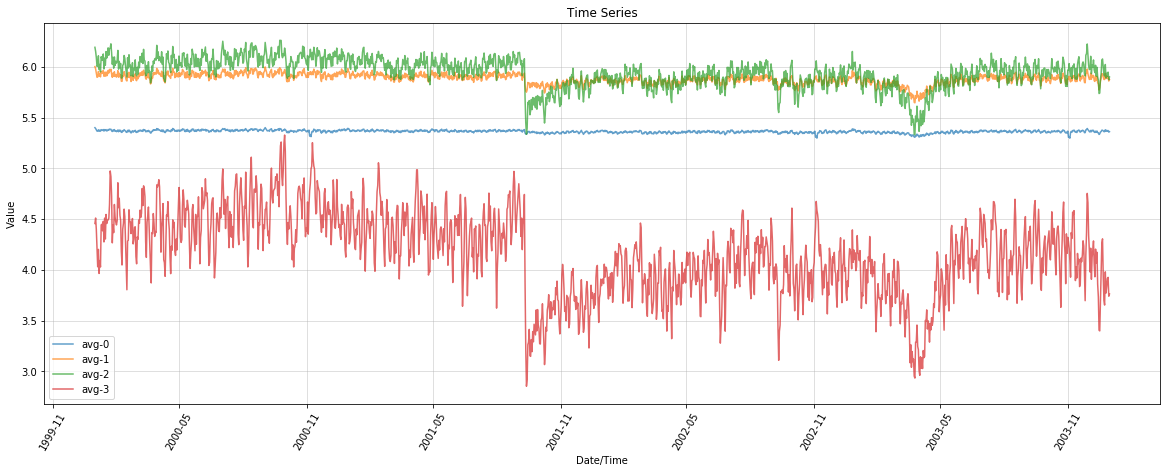

In [81]:
plot_series(smooth(avg_nyt, r = 1), start, stop)

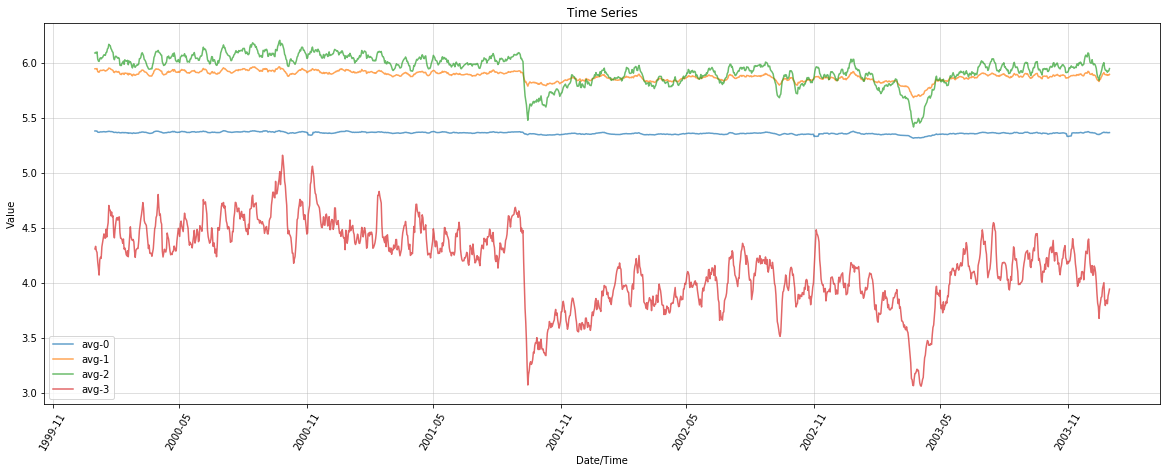

In [82]:
plot_series(smooth(avg_nyt, r = 3), start, stop)

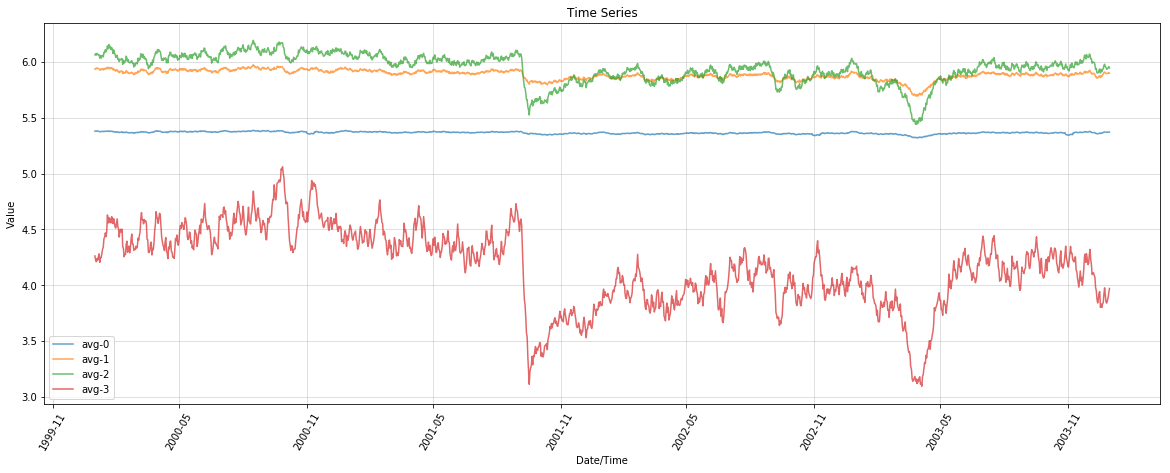

In [83]:
plot_series(smooth(avg_nyt, r = 5), start, stop)

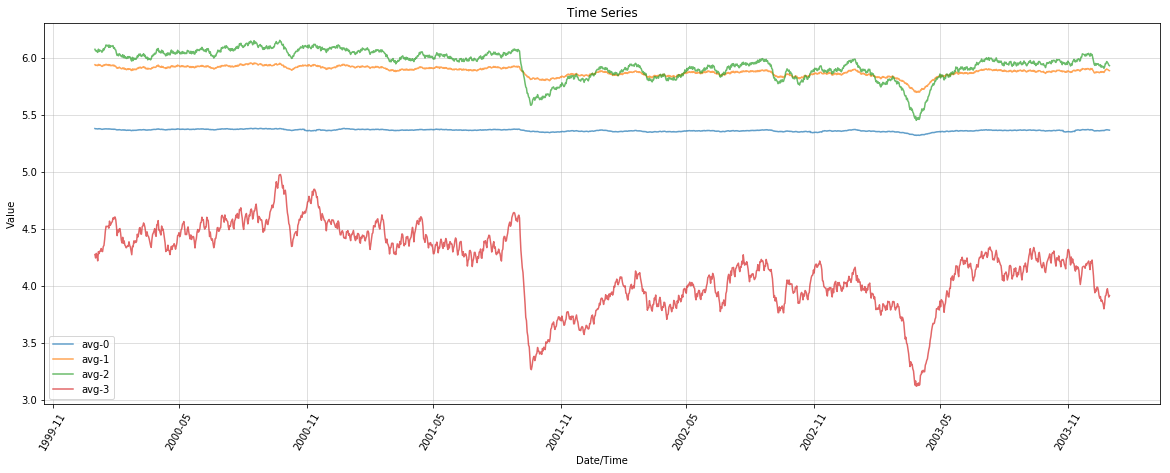

In [84]:
plot_series(smooth(avg_nyt, r = 8), start, stop)

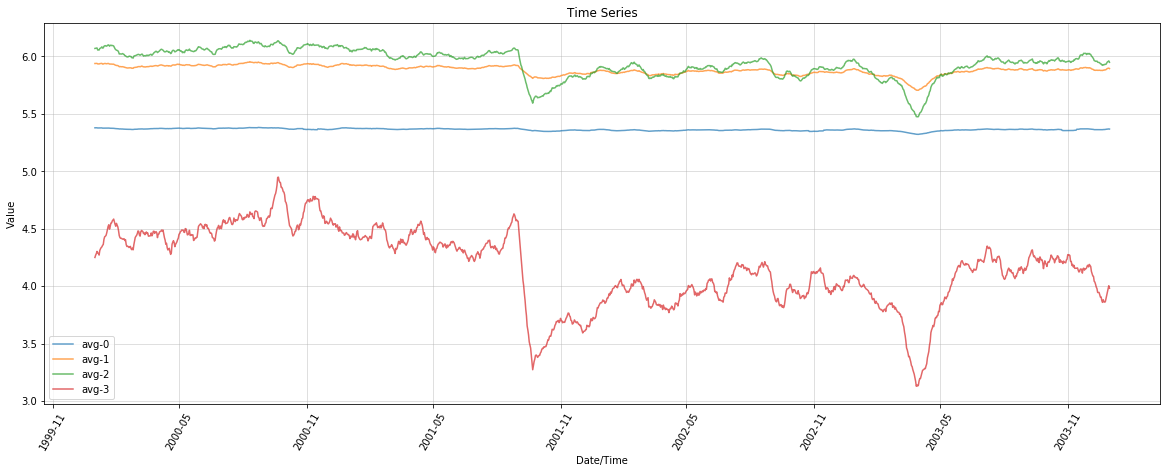

In [85]:
plot_series(smooth(avg_nyt, r = 10), start, stop)

**It looks like r=10 is the best choice.**

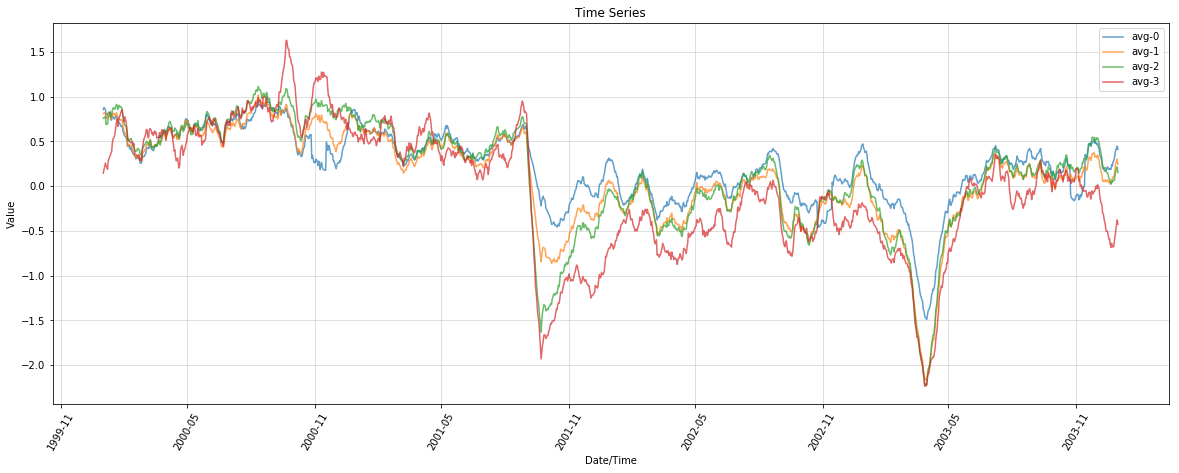

In [65]:
plot_series(smooth(standardize(avg_nyt), r = 10), start, stop)

__A12.__ _(2 pts)_ Now, use `plot_series()` again on the `avgs_series` values, but transform them in the following order:

1. `detrend_weekly()`
- `standardize()`
- `smooth()`

and be sure to use your value of `r_best` from the previous part of this assignment.

Once complete, take the resulting time series and apply `plot_series()`, again over the range defined by: 

- `start = "2000-01-01"`
- `stop = "2003-12-31"`

Discuss any observations on the effects of standardization and detrending in the response box below, and decide which stop-word window you think produced the 'best' series. Record your 'best' selected series/column from the `avgs_series` dataframe as the string/column name, i.e., `best_column = "avg-2"` and extract/store it under the object name `best_series`. You'll be using this selection _only_ throughout the remainder of the assignment.

<font color=blue>Standardization will bring all the data together around the average and deterending remove any weekly trend and spikes in the series. Data would be more conclusive if the window frame is wider. It means that the non-neutral words are playing a more important role in the averages. But maybe avg_3 is limiting the data too much by omitting most of the data. So I am choosing avg_2 as the best series.</font>

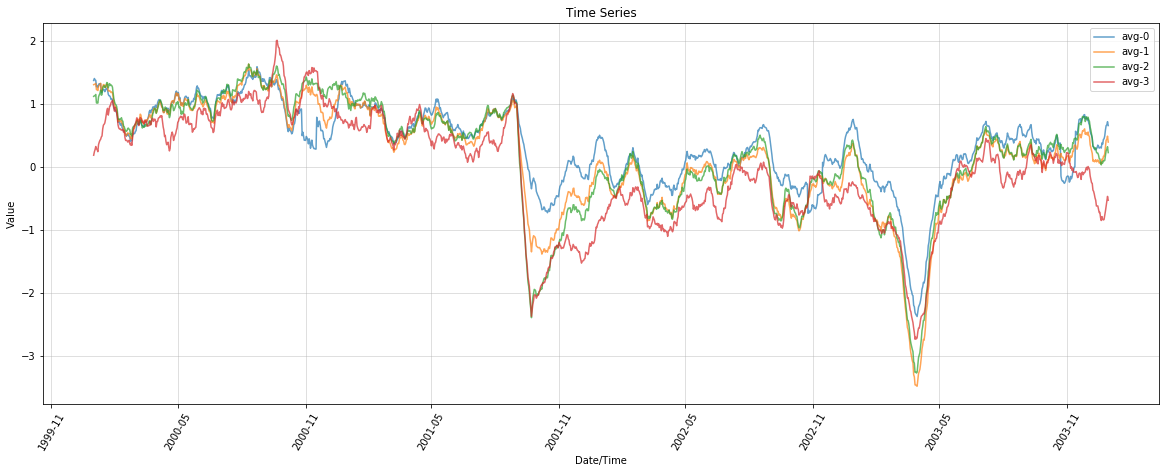

In [66]:
plot_series(smooth(standardize(detrend_weekly(avg_nyt)), r = 10), start, stop)

In [67]:
best_column = "avg-2"

In [68]:
best_series = avg_nyt[[best_column]]

__A13.__ _(5 pts)_ While smoothing helped us to visually observe some candidate big events on the time series, it will actually make it more difficult to pin down exactly where these shifts happended, and hence provide clues as to _why_ they happened. This is because one means we have for assessing a big 'drop', or, more generally a 'shift', is by looking at outlier _differences_ in the time series values. 

So, write a new function called `diff(ts)` that calculates _single-step, backward differences_ of `ts` and outputs them as another timeseries dataframe. In particular, this function should subtract the $t-1^\text{st}$ series values from the $t^\text{th}$. 

When this is done, apply your code in the following order to `best_series`:

1. `detrend_weekly()`
- `standardize()`
- `diff()`

Then, `.sort(by = best_column)` the result and store it as `diffs`. Finally, print the `.head()` and `.tail()` of the result. Considering the change of sign (negative for `.head()` and positive for `.tail()`), do you recognize any dates that might correspond to sentiment-charged news reporting major geopolitical events?  In the response box below, discuss any of these specific dates and possibilities.

__Important__: the output of `diff()` should always be one row smaller than its input, since the first (`0`-index) row has none previous to subtract. 

<font color=blue>In this data, wherever we have a big number for the diffs, we can see a spike at the previous plot at that time and date, which means some thing important happened that day.</font> 

In [69]:
def diff(ts):
    columns_list = [x for x in ts.columns]
    diff_ts = pd.DataFrame(index = ts.index[1:])
    #for subtraction I shifted the array by one row and then subtracted the two vectors and removed the first row
    for col in columns_list:
        column = np.array(ts[col])
        dummy1 = np.insert(column, column.shape, 0)
        dummy2 = np.insert(column, 0, 0)
        dummy3 = dummy1-dummy2
        diff_ts[col] = dummy3[1:-1]
    return diff_ts

In [70]:
diffs = diff(standardize(detrend_weekly(best_series)))

In [71]:
diffs.sort_values(best_column, inplace=True)

In [72]:
diffs.head()

,avg-2
2001-09-12,-6.072661
1999-04-14,-3.632798
1996-07-24,-3.361089
1988-08-23,-3.284561
1995-07-12,-3.278032


In [73]:
diffs.tail()

,avg-2
1995-05-14,3.636487
1991-11-10,3.717994
1992-08-01,3.996021
1997-01-07,4.209931
2006-03-29,4.294988


__A14.__ _(10 pts)_ To observe candidate events, modify your original `plot_series` function into a new one:

- `plot_series_top_diffs(ts, start, stop, ylabel, top = 5, legend = True)` 

so as to additionally visualize the `top` (most extreme) values determined from an application of `diff()` to `ts`, i.e., the `.head(top)` and `.tail(top)` from the sorted output of `diff()`.  

Beyond `plot_series()`, this function should, intuitively, exhibit 'points on a line' over a specified `start`/`stop` range. As in part __C12__, your final product should exhibit the series with transformations in the following order:

1. `detrend_weekly()`
- `standardize()`
- `smooth()`

__Important:__ `diff()` should only be applied to _un-smoothed_ data. In other words, for the `2*top` points we'd like to retrieve from `diff` the order of transformations should be:

1. `detrend_weekly()`
- `standardize()`
- `diff()`

So, be sure to pass only _detrended_, _standardized_ series to the `plot_series_top_diffs` function. Application of `diff()` and `smooth()` should then be applied to the passed `ts` to identify the `top` times along the `smooth()`'d values for plotting.

Also, as with parts __C10__&mdash;__C13__, your final code should be exhibited over the range

- `start = "2000-01-01"`
- `stop = "2003-12-31"`

but now just in application to the `best_series` values.

When this is complete, exhibit the function's output setting `top = 5`. Then, discuss the locations of these points below in the context of the potential events you identified in __C13__. Is the analysis all consistent?

<font color=blue>This will detect the peaks and lows of the time series based on the average sentiment value of the day. One problem is that sad news and happy news can cancel out each other in the average calculations and in this way prevent us from detecting an important event. </font> 

In [74]:
def plot_series_top_diffs(ts_input_argument, start, stop, ylabel, top, legend):
    ts = standardize(detrend_weekly(ts_input_argument))
    datestart = datetime.strptime(start, '%Y-%m-%d')
    datestop = datetime.strptime(stop, '%Y-%m-%d')
    sub_ts = ts.loc[(ts.index >= datestart) & (ts.index <= datestop)]
    diff_df = diff(sub_ts)
    diff_df.sort_values(best_column, inplace=True)
    annotations = []
    for j in [p for p in diff_df.head(top).index.strftime('%Y-%m-%d')]:
        annotations.append(j)
    for k in [p for p in diff_df.tail(top).index.strftime('%Y-%m-%d')]:
        annotations.append(k)
    

    sub_ts2 = smooth(sub_ts[[best_column]], r = 10)#smooth the data
    
    markers = sub_ts2.index.isin(annotations)
    print(type(markers), markers.shape)
    marker_ts = sub_ts2[markers]
    fig, ax1 = plt.subplots(1,1,figsize=(20,7))
    ax1.plot(sub_ts2.index, sub_ts2, 'b-', label = best_column)       
    ax1.plot(marker_ts.index, marker_ts,'rD', label  = 'Maximum Difference Points')
    fig.autofmt_xdate()
    
    plt.grid(alpha=0.5)
    plt.xlabel('Date/Time')
    plt.ylabel(ylabel)
    plt.title('Time Series')
    if legend:
        plt.gca().legend()
    plt.xticks(rotation=60)
    plt.show()
    

In [75]:
start = "2000-01-01"
stop = "2003-12-31"

<class 'numpy.ndarray'> (1461,)


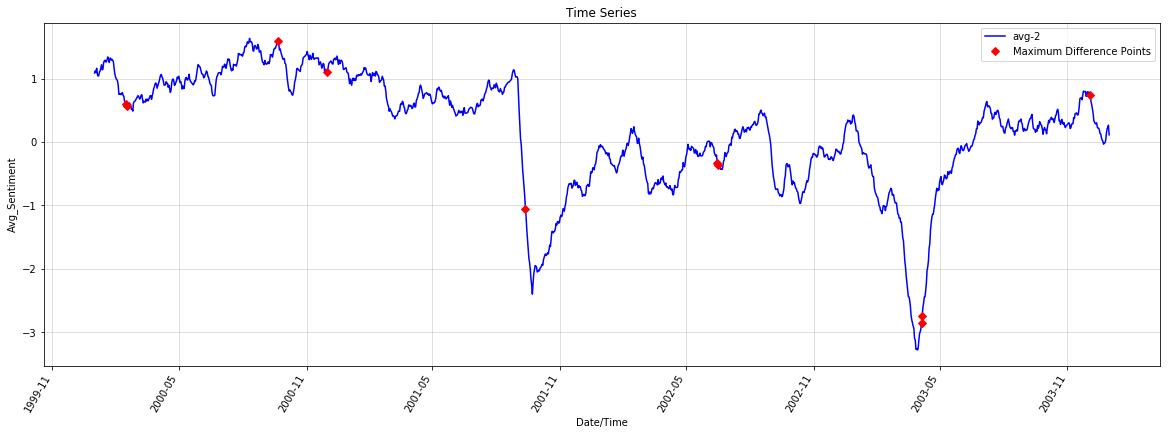

In [76]:
plot_series_top_diffs(best_series, start, stop, "Avg_Sentiment", top = 5, legend = True)